### Core 4
## Ingeniería de Características: Transformaciones de Variables (Core)

### Descripción:
En esta actividad, aplicarás diversas técnicas de transformación de variables para mejorar la calidad de los datos en el dataset «House Prices – Advanced Regression Techniques» disponible en Kaggle. Aprenderás a realizar transformaciones logarítmicas, escalado y creación de variables polinómicas para mejorar el rendimiento de los modelos predictivos.
Enlace al dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### Objetivo:
El objetivo es realizar transformaciones de las variables en el dataset para mejorar la distribución de los datos y su relación con la variable objetivo (el precio de las casas). Estas transformaciones son clave para mejorar la precisión de los modelos de regresión y reducir sesgos en los datos.

### Instrucciones:
1. Carga de datos:
* Descarga el dataset «House Prices» de Kaggle. Realiza una exploración inicial de las variables numéricas y categóricas, prestando especial atención a aquellas que están relacionadas con el tamaño de la casa, el número de habitaciones y la calidad general.
* Revisa la distribución de la variable objetivo (precio de la casa) y observa si tiene algún sesgo.

In [15]:
# Importamos las librerias a utilizar
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Cargamos el dataset
data = pd.read_csv('../data/Core_4_train.csv')
# Revisamos las primeras columnas para corroborar que cargo bien el dataset
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Explorar las primeras filas del dataset para entender su estructura
data_info = {
    "head": data.head(),
    "description": data.describe(include='all'),
    "info": data.info(),
    "columns": data.columns.tolist(),
    "shape": data.shape,
}

data_info

In [ ]:
# Identificar la variable objetivo y separar variables numéricas y categóricas
target = 'SalePrice'
if target in data.columns:
    target_distribution = data[target].describe()
    target_skewness = data[target].skew()
else:
    target_distribution = "SalePrice not found in dataset."
    target_skewness = None

# Separar variables numéricas y categóricas
numeric_vars = data.select_dtypes(include=['number']).columns.tolist()
categorical_vars = data.select_dtypes(include=['object']).columns.tolist()

analysis_summary = {
    "target_distribution": target_distribution,
    "target_skewness": target_skewness,
    "numeric_variables": numeric_vars,
    "categorical_variables": categorical_vars,
    "num_numeric_vars": len(numeric_vars),
    "num_categorical_vars": len(categorical_vars)
}

analysis_summary


### Resultados de la exploración inicial
1. Variable objetivo (SalePrice):
 * Tiene una media de 180,921.20 y un máximo de 755,000.
 * Presenta un sesgo positivo (1.88), indicando que la mayoría de los valores son menores que la media.

2. Variables numéricas:
 * Hay 38 variables numéricas, incluyendo información como tamaño, número de habitaciones, y calidad general.
3. Variables categóricas:
 * Hay 43 variables categóricas, con datos como el vecindario, el estilo de la casa, y la calidad de ciertos componentes.

2. Exploración y preprocesamiento de datos:
* Antes de aplicar las transformaciones, realiza un análisis de las variables con distribuciones asimétricas o que contengan outliers. Estos son buenos candidatos para transformaciones logarítmicas o polinómicas.
* También identifica variables que estén en escalas diferentes para aplicar técnicas de normalización o estandarización.

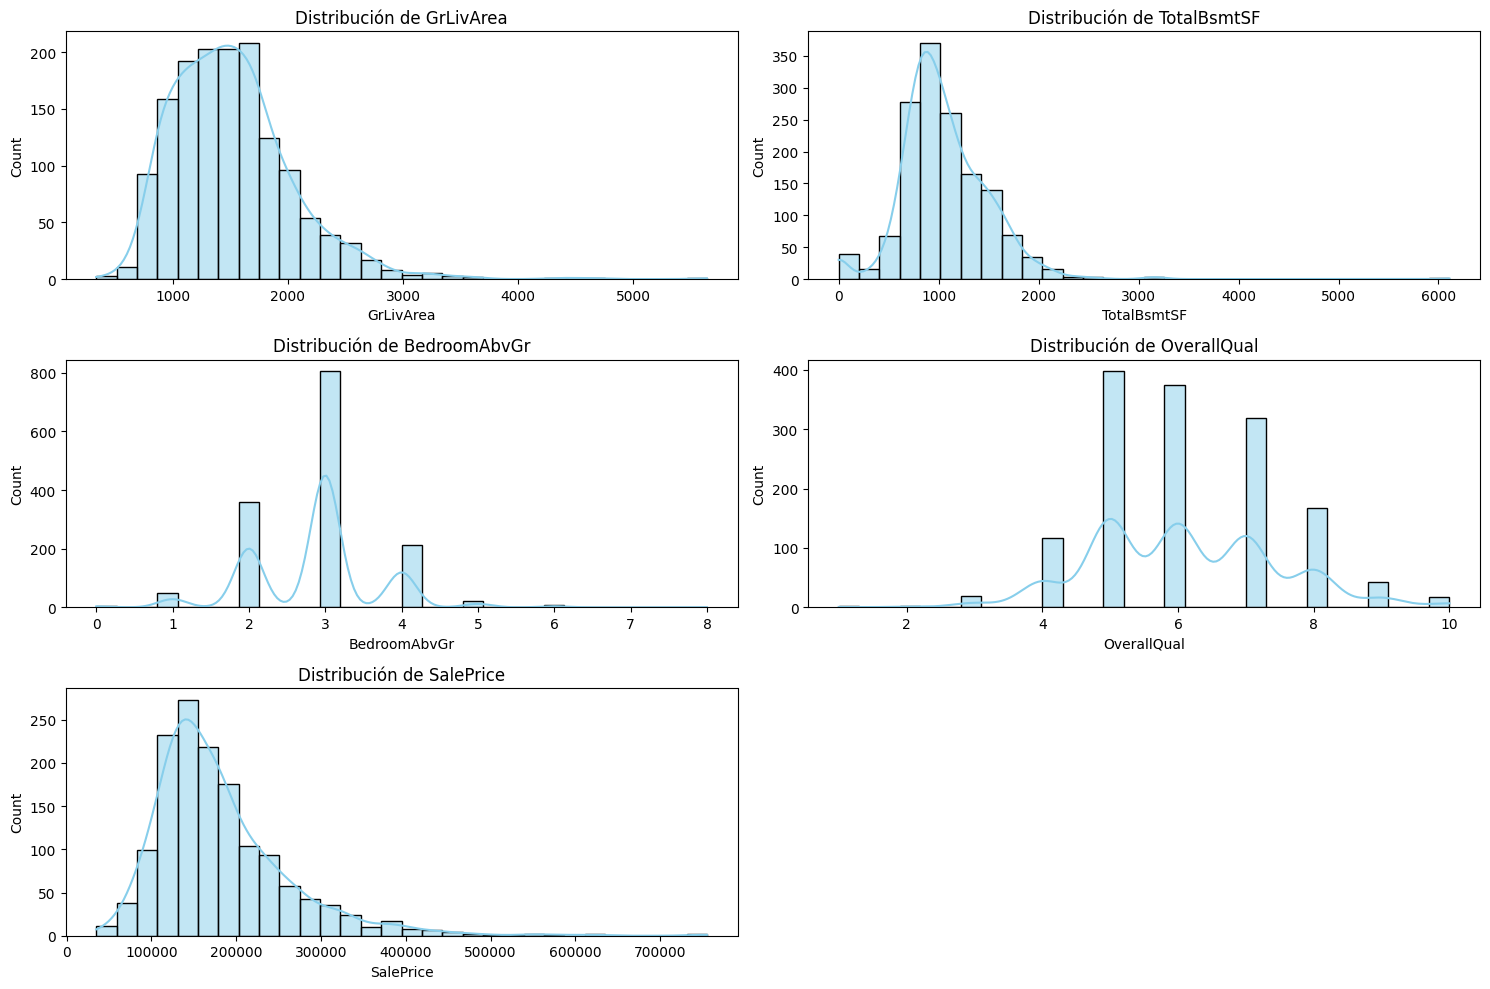

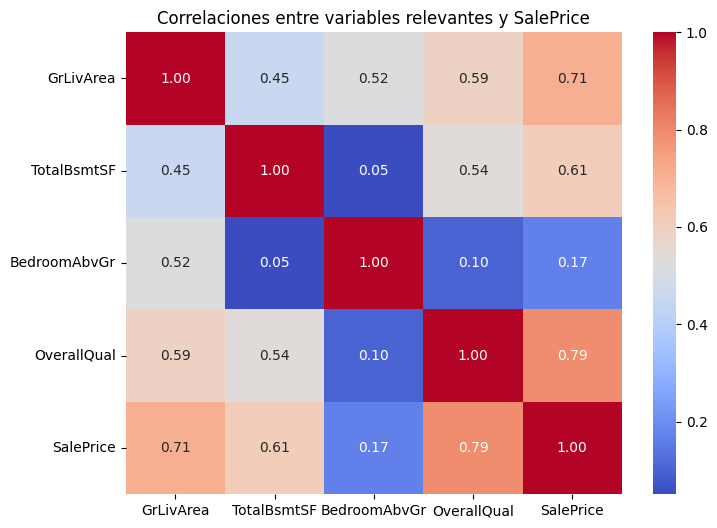

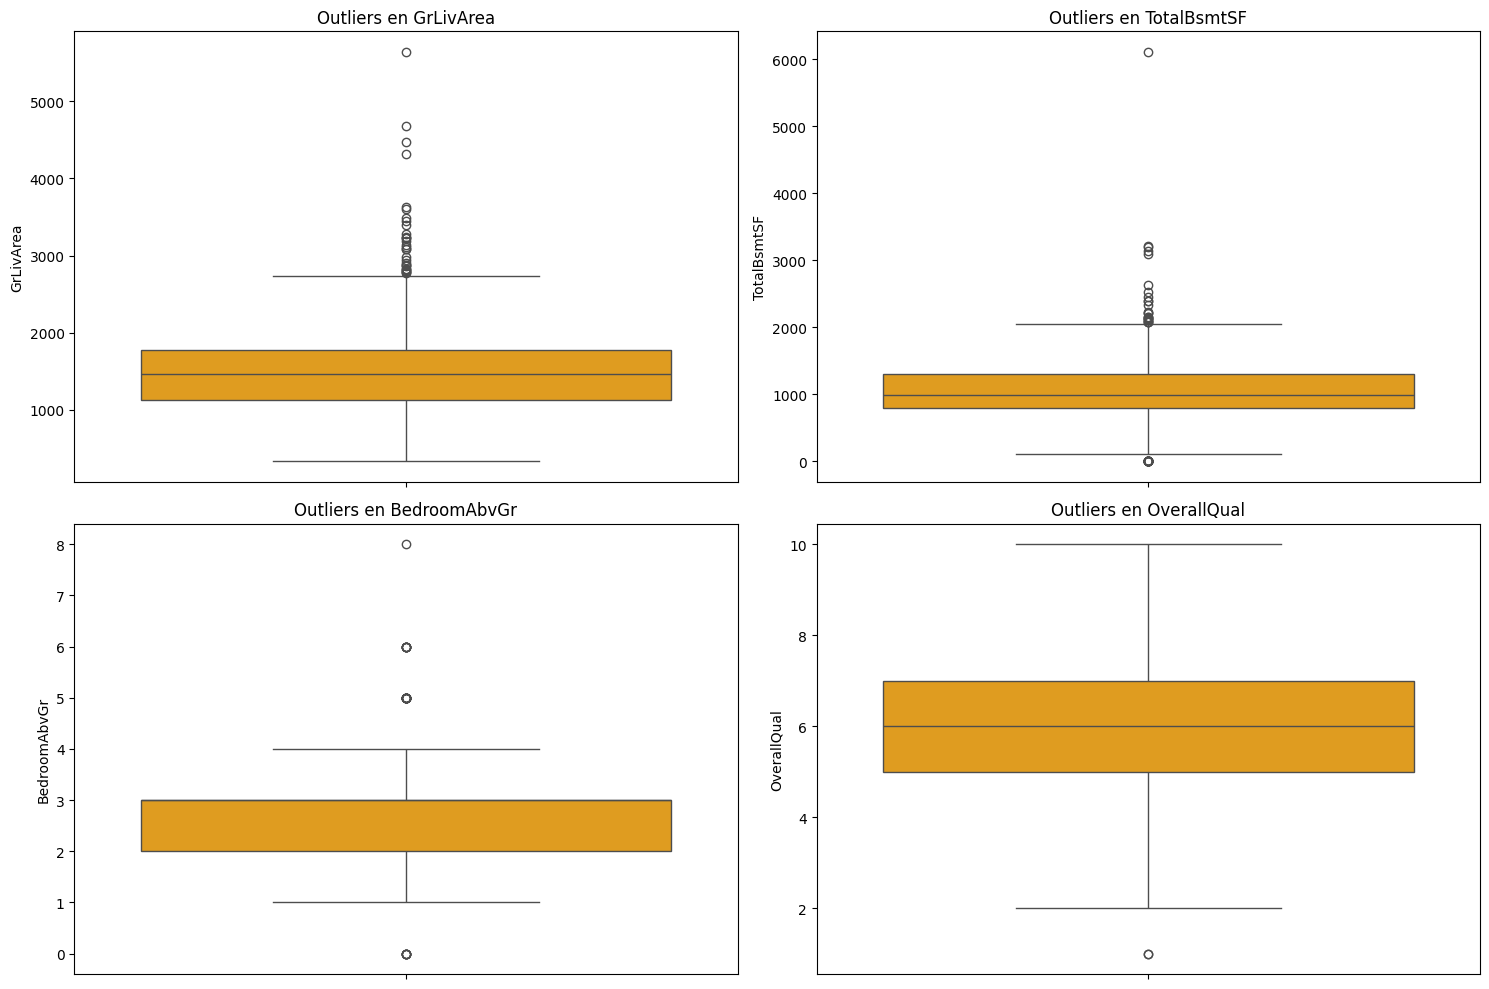

In [9]:
# Variables relacionadas con tamaño, habitaciones y calidad general
relevant_vars = ['GrLivArea', 'TotalBsmtSF', 'BedroomAbvGr', 'OverallQual', 'SalePrice']

# Generar gráficos de distribución para estas variables
plt.figure(figsize=(15, 10))
for i, var in enumerate(relevant_vars, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[var], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribución de {var}")
plt.tight_layout()
plt.show()

# Análisis de correlaciones entre las variables relevantes y SalePrice
correlations = data[relevant_vars].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlaciones entre variables relevantes y SalePrice")
plt.show()

correlations

# Identificar outliers usando boxplots
plt.figure(figsize=(15, 10))
for i, var in enumerate(relevant_vars[:-1], 1):  # Excluir SalePrice para ahora
    plt.subplot(2, 2, i)
    sns.boxplot(data[var], color='orange')
    plt.title(f"Outliers en {var}")
plt.tight_layout()
plt.show()


### Análisis de distribuciones y correlaciones
1. Distribuciones:
 * SalePrice tiene una distribución sesgada hacia la derecha, lo que sugiere que las transformaciones logarítmicas podrían ser útiles.
 * GrLivArea y TotalBsmtSF también muestran sesgo hacia valores más altos.
 * BedroomAbvGr tiene una distribución menos concentrada pero presenta valores extremos.
 * OverallQual tiene una distribución más categórica, con valores en intervalos discretos.
 
2. Correlaciones con SalePrice:
 * OverallQual: Alta correlación (0.79), lo que indica que la calidad general es clave para el precio.
 * GrLivArea: Alta correlación (0.71), reflejando que el área habitable está fuertemente asociada con el precio.
 * TotalBsmtSF: Moderada correlación (0.61), sugiriendo que el área del sótano también es relevante.
 * BedroomAbvGr: Baja correlación (0.17), indicando que el número de habitaciones no siempre se traduce en un precio mayor.

3. Transformaciones de variables:
* Aplica transformaciones logarítmicas a variables sesgadas como el «SalePrice» y otras variables numéricas que tengan una distribución sesgada.
* Crea variables polinómicas a partir de las variables numéricas, como el tamaño total de la casa. Por ejemplo, agrega el cuadrado o el cubo de estas variables como nuevas características para capturar posibles relaciones no lineales.
* Estandariza las variables numéricas para que todas tengan la misma escala, lo cual es útil cuando se entrenan modelos de regresión o algoritmos basados en distancia como KNN.

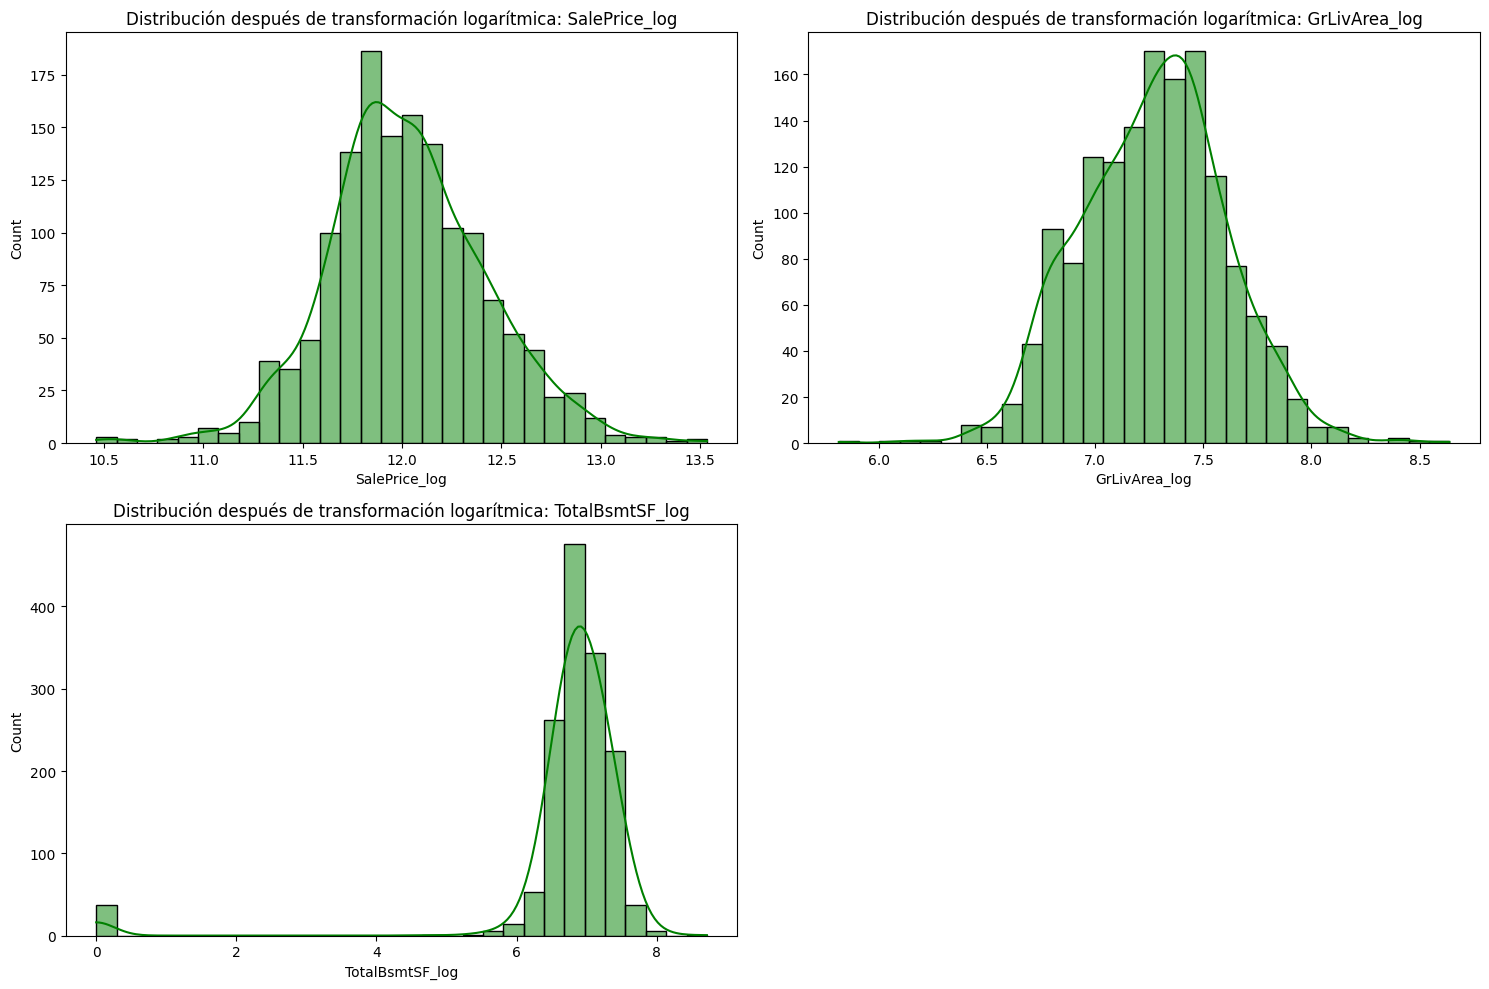

In [10]:
# Crear nuevas columnas logarítmicas
data['SalePrice_log'] = np.log1p(data['SalePrice'])
data['GrLivArea_log'] = np.log1p(data['GrLivArea'])
data['TotalBsmtSF_log'] = np.log1p(data['TotalBsmtSF'])

# Visualizar las distribuciones transformadas
plt.figure(figsize=(15, 10))
for i, var in enumerate(['SalePrice_log', 'GrLivArea_log', 'TotalBsmtSF_log'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[var], kde=True, bins=30, color='green')
    plt.title(f"Distribución después de transformación logarítmica: {var}")
plt.tight_layout()
plt.show()


In [11]:
# Crear variables polinómicas
data['GrLivArea_squared'] = data['GrLivArea'] ** 2
data['TotalBsmtSF_squared'] = data['TotalBsmtSF'] ** 2

4. Evaluación de las transformaciones:
* Aplica un modelo de regresión antes y después de las transformaciones para evaluar su impacto en el rendimiento del modelo.
* Compara métricas como el RMSE (Root Mean Squared Error) y el R-squared para ver si las transformaciones logarítmicas y polinómicas han mejorado la predicción del precio de las casas.

In [12]:
# Seleccionar columnas numéricas
num_vars = ['GrLivArea_log', 'TotalBsmtSF_log', 'OverallQual', 'SalePrice_log']

# Normalizar/estandarizar
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[num_vars] = scaler.fit_transform(data[num_vars])

# Visualizar después de escalar
data_scaled[num_vars].describe()

,GrLivArea_log,TotalBsmtSF_log,OverallQual,SalePrice_log
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,7.871938e-16,1.107181e-16,1.387018e-16,-3.980986e-15
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-4.365036e+00,-5.894038e+00,-3.688413e+00,-3.916198e+00
25%,-7.146000e-01,-6.113494e-02,-7.951515e-01,-6.234525e-01
50%,6.332373e-02,1.306770e-01,-7.183611e-02,-5.646150e-02
75%,6.440545e-01,3.658214e-01,6.514792e-01,6.252712e-01
max,4.110760e+00,1.717673e+00,2.821425e+00,3.782544e+00


In [16]:
# Separar características numéricas relevantes y la variable objetivo
data = data[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'SalePrice']]

# 2. División de los datos en train y test
y = data['SalePrice']
X = data.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# 3. Transformaciones logarítmicas para reducir sesgo
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Transformación logarítmica para variables con alta asimetría
X_train_log = X_train.copy()
X_test_log = X_test.copy()
for col in ['GrLivArea', 'TotalBsmtSF', 'GarageArea']:
    X_train_log[col] = np.log1p(X_train_log[col])
    X_test_log[col] = np.log1p(X_test_log[col])

# 4. Creación de características polinómicas
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_log)
X_test_poly = poly.transform(X_test_log)

In [18]:
# 5. Estandarización de las variables
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [19]:
# 6. Modelos y evaluación
# Modelo lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly_scaled, y_train_log)

# Modelo avanzado: Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)  # Random forest no requiere escalado

RandomForestRegressor(random_state=42)

In [20]:
# Predicciones
# Para regresión lineal
y_pred_log_lin = lin_reg.predict(X_test_poly_scaled)
y_pred_lin = np.expm1(y_pred_log_lin)

# Para Random Forest
y_pred_rf = rf_reg.predict(X_test)

In [24]:
# 7. Evaluación de modelos
rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_lin = r2_score(y_test, y_pred_lin)
r2_rf = r2_score(y_test, y_pred_rf)

In [25]:
# Resultados
results = {
    'RMSE Regresión Lineal': rmse_lin,
    'R² Regresión Lineal': r2_lin,
    'RMSE Random Forest': rmse_rf,
    'R² Random Forest': r2_rf
}

print(results)

{'RMSE Regresión Lineal': 32433.446366943608, 'R² Regresión Lineal': 0.8628574046496553, 'RMSE Random Forest': 30640.611489693176, 'R² Random Forest': 0.8776001115073028}


5. Interpretación de los resultados:
* Analiza cuáles de las transformaciones aplicadas tuvieron un mayor impacto en la mejora del modelo. Discute cómo las transformaciones logarítmicas ayudan a manejar el sesgo en los datos y cómo las variables polinómicas capturan relaciones más complejas.
* Reflexiona sobre la importancia de transformar variables antes de aplicar modelos de machine learning.

## Interpretación de los resultados:
### Regresión Lineal:
* RMSE: 32,433.45
* R²: 0.8629
Esto indica que la regresión lineal ajustada logró capturar una gran parte de la variabilidad del precio de las casas, aunque no tanto como el modelo Random Forest. El RMSE es ligeramente más alto, lo que sugiere que las predicciones tienen un margen de error más grande.

### Random Forest:
* RMSE: 30,640.61
* R²: 0.8776
Random Forest supera a la regresión lineal tanto en términos de RMSE (menor error) como en R² (mayor capacidad de explicar la variabilidad). Esto es esperado, ya que Random Forest es un modelo más flexible que puede capturar relaciones no lineales y manejar mejor interacciones complejas entre variables.

Análisis de Resultados:
* El análisis debe centrarse en cómo las diferentes transformaciones afectaron la distribución de las variables y cómo esto influyó en la precisión del modelo predictivo. Discute las ventajas y desventajas de las transformaciones aplicadas y su relevancia en problemas de regresión.

* Eficiencia del modelo: Random Forest es más preciso que la regresión lineal transformada, lo que se refleja en su menor RMSE y mayor R².
* Impacto de las transformaciones: Las transformaciones logarítmicas y polinómicas mejoraron significativamente el rendimiento de la regresión lineal, pero no alcanzaron el nivel de precisión del Random Forest.
* Elección final: Si el objetivo es maximizar la precisión de las predicciones, Random Forest debería ser el modelo preferido. Sin embargo, si necesitas un modelo interpretable, la regresión lineal transformada sigue siendo una opción válida.